# Load & Set Up Data

In [3]:
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import time
from datetime import timedelta

import cv2 
import contours as ct
 
%load_ext autoreload
%autoreload 2

# image directories
imgdir_toronto_scenes = "../images/data_TorontoScenes/CP_images/" # real images from TorontoScenes dataset
imgdir_SUN397 = "../images/SUN397_IMAGES/" # real images from SUN397 dataset
imgdir_ai_sd= "../images/stableDiffusion_dataset_rev2/IMAGES/" # AI images from stableDiffusion dataset

# scene categories
scene_categories = ['forest', 'highway', 'cockpit', 'bedroom']

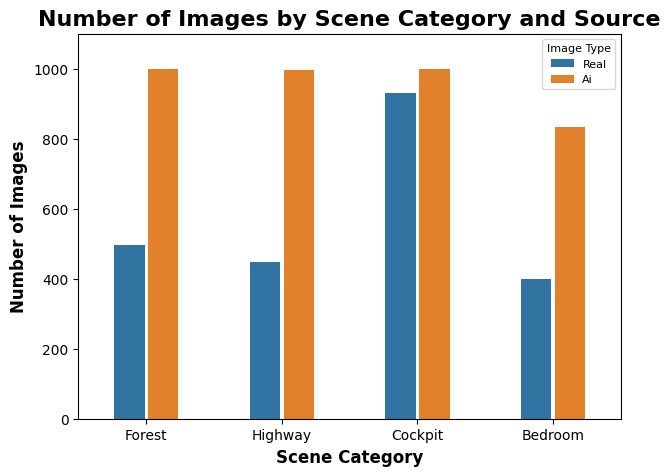

In [4]:
# load images and labels into a dataframe -- use the full file path
imgs_list = glob.glob(f'{imgdir_toronto_scenes}/**', recursive=True) \
            + glob.glob(f'{imgdir_SUN397}/**', recursive=True) \
            + glob.glob(f'{imgdir_ai_sd}/**', recursive=True)
            
image_extensions = ('.jpg', '.jpeg', '.png')
imgs_list = [f for f in imgs_list if os.path.isfile(f) and f.lower().endswith(image_extensions)]
            

# create formatted df with the scene categories and source (ai or real)
df = pd.DataFrame(imgs_list, columns=['img_path'])
df['scene_category'] = df['img_path'].apply(lambda x: next((cat for cat in scene_categories if cat in x.lower()), None))
df['img_type'] = df['img_path'].apply(lambda x: 'ai' if 'stableDiffusion' in x else 'real')
df = df.dropna(subset=['scene_category'])

# show distribution of data
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='scene_category', hue='img_type', width=0.5, gap=0.1)
plt.title('Number of Images by Scene Category and Source', fontsize=16, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.xlabel('Scene Category', fontsize=12, fontweight='bold')
plt.xticks(ticks=np.arange(4), labels=[cat.capitalize() for cat in scene_categories])
plt.ylim(0, 1100)

# adjust legend fonts
handles, labels = plt.gca().get_legend_handles_labels()
labels = [label.capitalize() for label in labels]
plt.legend(handles, labels, title='Image Type', title_fontsize='8', fontsize='8')


In [5]:
df.sample(10)

,img_path,scene_category,img_type
5725,../images/stableDiffusion_dataset_rev2/IMAGES/...,bedroom,ai
5293,../images/stableDiffusion_dataset_rev2/IMAGES/...,forest,ai
1080,../images/SUN397_IMAGES/dataset/bedroom/IMG_00...,bedroom,real
2623,../images/stableDiffusion_dataset_rev2/IMAGES/...,bedroom,ai
797,../images/SUN397_IMAGES/dataset/forest/IMG_000...,forest,real
544,../images/SUN397_IMAGES/dataset/forest/IMG_002...,forest,real
4447,../images/stableDiffusion_dataset_rev2/IMAGES/...,highway,ai
4245,../images/stableDiffusion_dataset_rev2/IMAGES/...,cockpit,ai
4500,../images/stableDiffusion_dataset_rev2/IMAGES/...,forest,ai
3535,../images/stableDiffusion_dataset_rev2/IMAGES/...,cockpit,ai


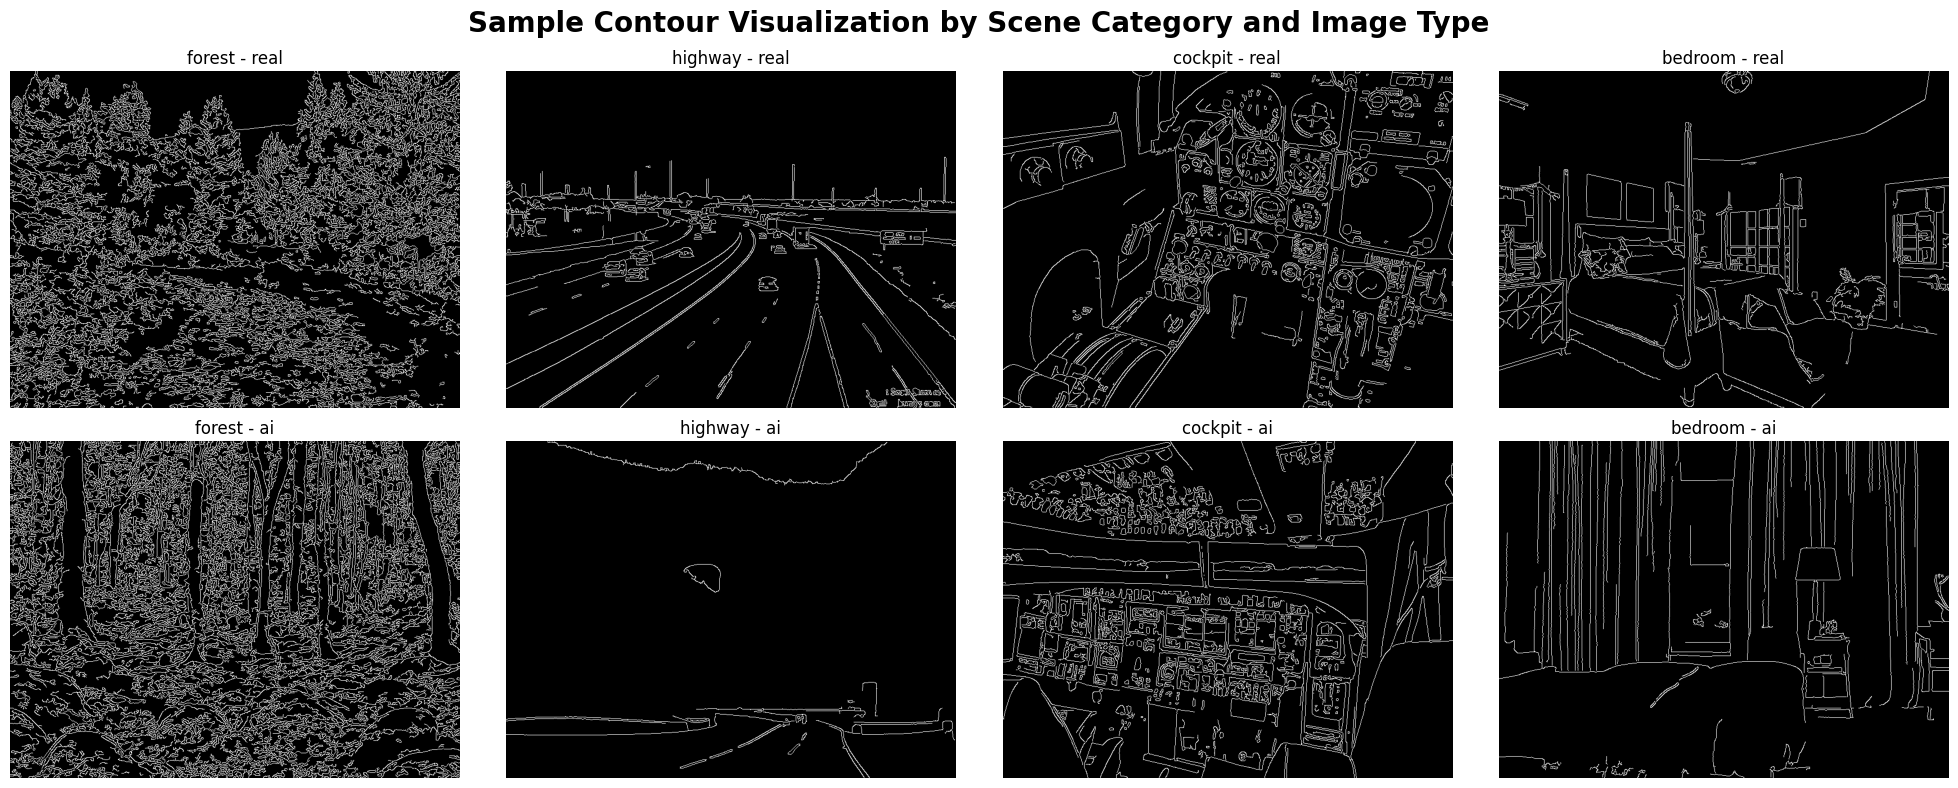

In [6]:
# sample images to show contours
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.tight_layout(pad=3.0)
fig.suptitle('Sample Contour Visualization by Scene Category and Image Type', fontsize=20, fontweight='bold')

for i, img_type in enumerate(['real', 'ai']):
    for j, cat in enumerate(scene_categories):
        
        # Get random sample from this category/type
        sample = df[(df['scene_category'] == cat) & 
                   (df['img_type'] == img_type)].sample(1)
        
        # Get contour image
        contour_img = ct.get_contour_image(sample['img_path'].iloc[0])
        
        # Plot
        axes[i,j].imshow(contour_img, cmap='gray')
        axes[i,j].set_title(f'{cat} - {img_type}')
        axes[i,j].axis('off')

plt.tight_layout()
plt.show()

# Part 1: Contour Analysis

In [7]:
def process_images(df, output_path='contour_metrics.csv', batch_size=10):
    """
    Process images and save metrics incrementally with checkpointing.
    
    Args:
        df: Input dataframe with 'img_path' column
        output_path: Path to save/load checkpoint CSV
        batch_size: Number of images to process before saving
    """
    # Load existing results if they exist
    if os.path.exists(output_path):
        existing_results = pd.read_csv(output_path)
        # Convert string representation of numpy array back to array
        if 'orientation_hist' in existing_results.columns:
            existing_results['orientation_hist'] = existing_results['orientation_hist'].apply(
                lambda x: np.fromstring(x.strip('[]'), sep=' ') if isinstance(x, str) else x
            )
        print(f"Loaded {len(existing_results)} existing results")
    else:
        existing_results = pd.DataFrame()
        print("Starting new processing")
    
    # Initialize results dataframe with same columns as input df
    results = pd.DataFrame(columns=df.columns)
    
    # Create empty lists for each metric
    metrics = {
        'num_contours': [],
        'mean_length': [],
        'std_length': [],
        'median_length': [],
        'orientation_hist': [],
        'junction_density': [],
        'parallelism_score': []
    }
    
    # Track processed paths
    processed_paths = set(existing_results['img_path'].values) if len(existing_results) > 0 else set()
    
    start_time = time.time()
    batch_start_time = time.time()
    
    for idx, row in df.iterrows():
        if row['img_path'] in processed_paths:
            continue
            
        try:
            # Get contour stats
            stats = ct.get_contour_stats(row['img_path'])
            
            # Store all metrics
            for metric in metrics:
                metrics[metric].append(stats[metric])
            
            # Store original row data
            results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)
            
            # Save checkpoint every batch_size images
            if (idx + 1) % batch_size == 0:
                batch_time = time.time() - batch_start_time
                print(f"Processed batch ending at index {idx+1}, "
                      f"batch time: {timedelta(seconds=batch_time)}")
                
                # Create temporary dataframe with current batch
                temp_df = results.copy()
                for metric in metrics:
                    temp_df[metric] = metrics[metric]
                
                # Combine with existing results
                if len(existing_results) > 0:
                    combined_df = pd.concat([existing_results, temp_df], ignore_index=True)
                else:
                    combined_df = temp_df
                
                # Save to CSV
                # Convert orientation_hist to string for CSV storage
                combined_df['orientation_hist'] = combined_df['orientation_hist'].apply(
                    lambda x: np.array2string(x) if isinstance(x, np.ndarray) else x
                )
                combined_df.to_csv(output_path, index=False)
                
                # Reset batch timer
                batch_start_time = time.time()
                
        except Exception as e:
            print(f"Error processing {row['img_path']}: {str(e)}")
            continue
    
    # Final save for any remaining images
    if len(metrics['num_contours']) > 0:
        temp_df = results.copy()
        for metric in metrics:
            temp_df[metric] = metrics[metric]
        
        if len(existing_results) > 0:
            combined_df = pd.concat([existing_results, temp_df], ignore_index=True)
        else:
            combined_df = temp_df
            
        combined_df['orientation_hist'] = combined_df['orientation_hist'].apply(
            lambda x: np.array2string(x) if isinstance(x, np.ndarray) else x
        )
        combined_df.to_csv(output_path, index=False)
    
    total_time = time.time() - start_time
    print(f"\nTotal processing time: {timedelta(seconds=total_time)}")
    print(f"Total images processed: {len(results)}")
    
    return combined_df

In [ ]:
processed_df = process_images(df, 'contour_metrics.csv', 10)

Starting new processing
Processed batch ending at index 40, batch time: 0:01:00.084859
Processed batch ending at index 60, batch time: 0:00:41.747532
Processed batch ending at index 70, batch time: 0:00:26.908358
Processed batch ending at index 80, batch time: 0:00:22.347493
Processed batch ending at index 90, batch time: 0:00:15.313587
Processed batch ending at index 120, batch time: 0:00:28.573091


In [5]:
img_path = df.sample(1)['img_path'].values[0]

# Get basic contours
contours = ct.get_contours(img_path)

# Get comprehensive stats
stats = ct.get_contour_stats(img_path)
print(f"Number of contours: {stats['num_contours']}")
print(f"Mean contour length: {stats['mean_length']:.2f}")

Number of contours: 253
Mean contour length: 125.19


In [14]:
# Sample size
n_samples = 50  # adjust this number as needed

# Sample evenly from each category and source type
df_sample = df.groupby(['scene_category', 'img_type']).apply(
    lambda x: x.sample(min(len(x), n_samples))
).reset_index(drop=True)

# Time the processing
start_time = time.time()

# Process the sampled images
df_sample['contour_stats'] = df_sample['img_path'].apply(ct.get_contour_stats)

# Unpack statistics
df_sample['num_contours'] = df_sample['contour_stats'].apply(lambda x: x['num_contours'])
df_sample['mean_length'] = df_sample['contour_stats'].apply(lambda x: x['mean_length'])
df_sample['std_length'] = df_sample['contour_stats'].apply(lambda x: x['std_length'])
df_sample['median_length'] = df_sample['contour_stats'].apply(lambda x: x['median_length'])
df_sample['orientation_hist'] = df_sample['contour_stats'].apply(lambda x: x['orientation_hist'])
df_sample['junction_density'] = df_sample['contour_stats'].apply(lambda x: x['junction_density'])
df_sample['parallelism'] = df_sample['contour_stats'].apply(lambda x: x['parallelism'])

end_time = time.time()
processing_time = end_time - start_time

print(f"Processed {len(df_sample)} images in {timedelta(seconds=processing_time)}")

# Quick summary of what we processed
print("\nSample distribution:")
print(pd.crosstab(df_sample['scene_category'], df_sample['img_type']))

/var/folders/t8/zrbyfcbx4kqf0hcthdnmtb0w0000gn/T/ipykernel_77750/2199366010.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby(['scene_category', 'img_type']).apply(


KeyboardInterrupt: 

In [11]:
contour_features = ['num_contours', 'mean_length', 'std_length', 'median_length', 'junction_density', 'parallelism']

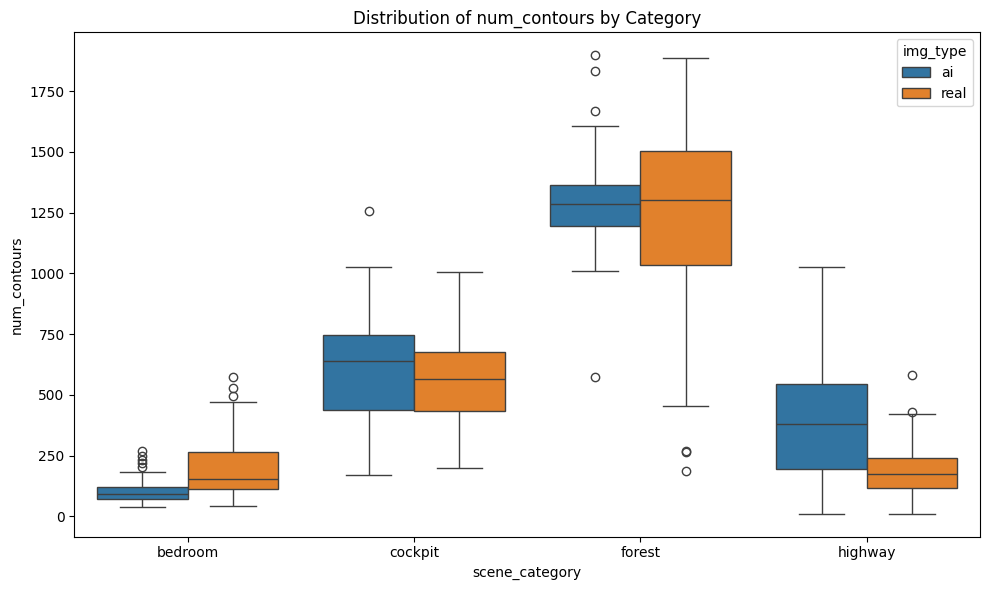

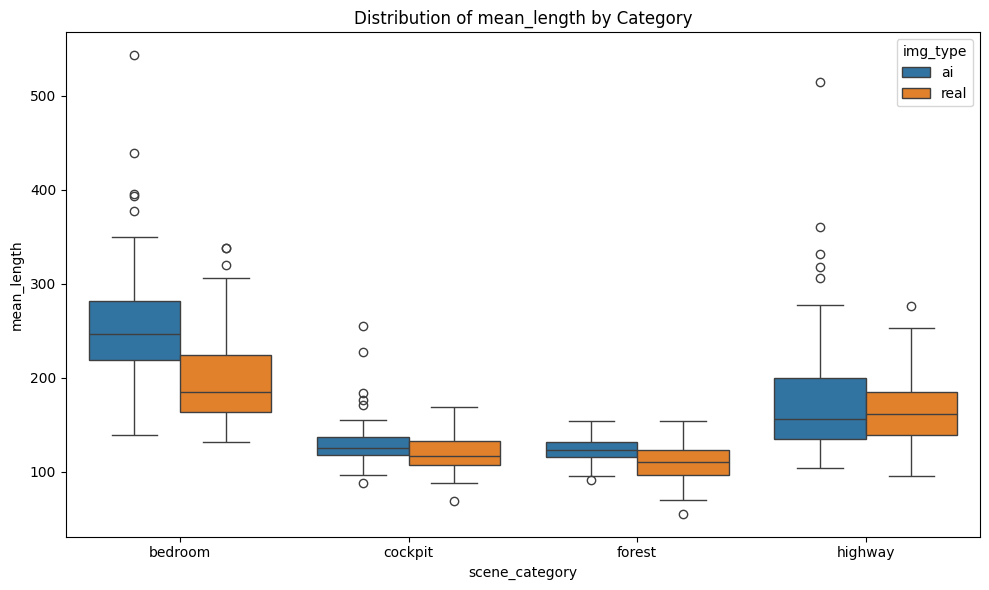

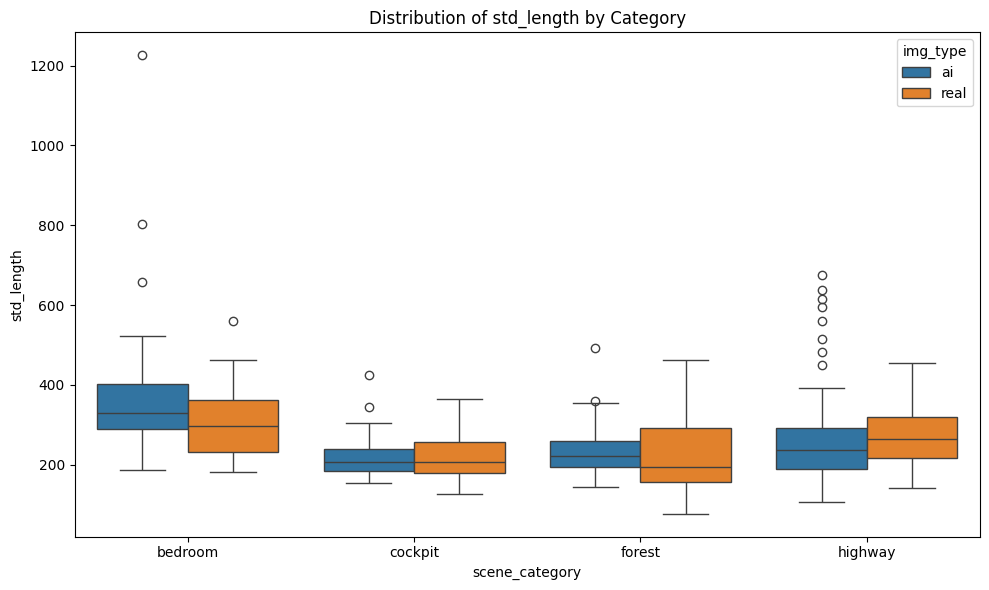

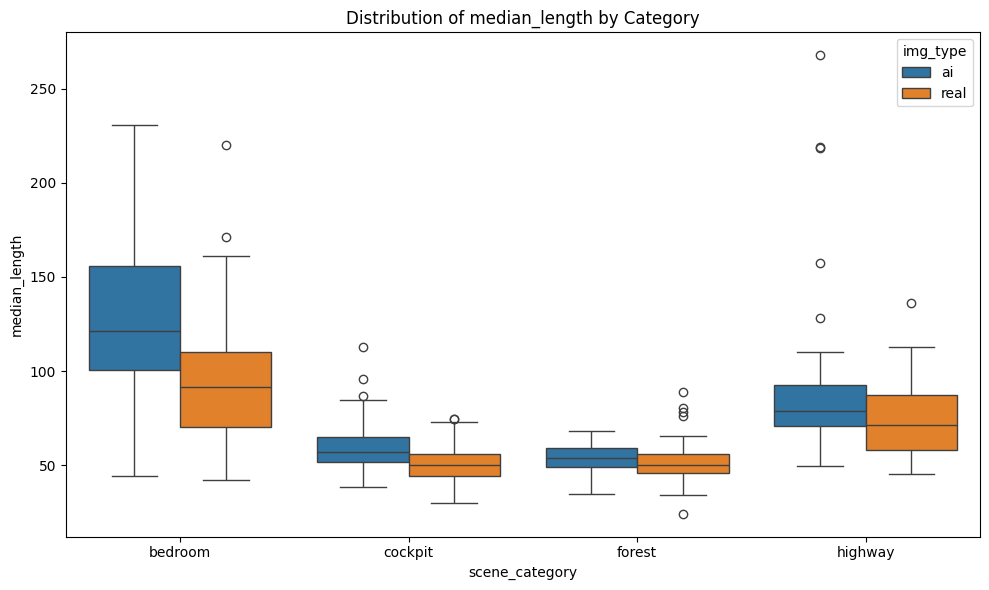

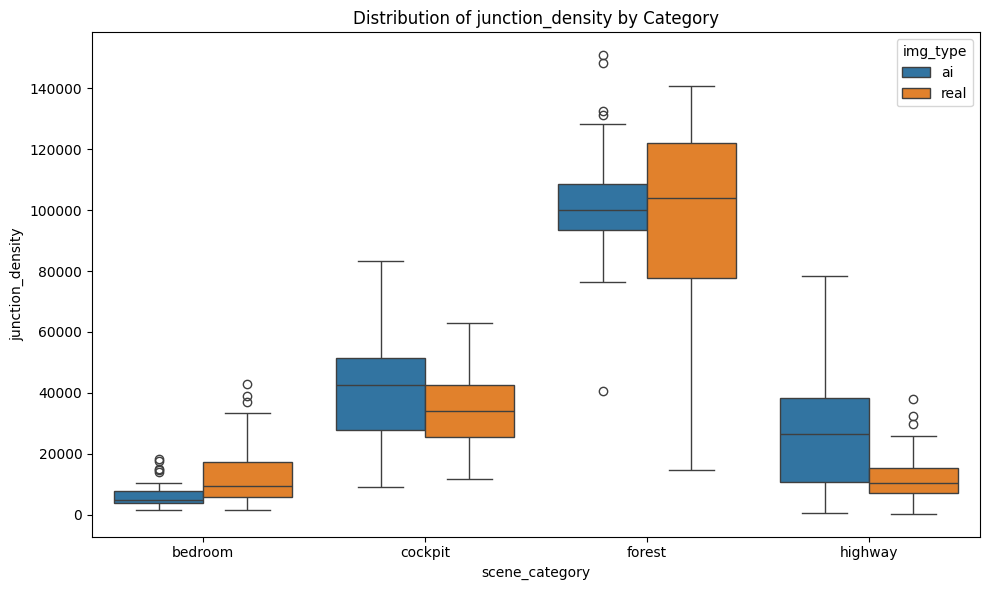

In [12]:
#plot distributions for each feature

for feature in contour_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_sample, x='scene_category', y=feature, hue='img_type')
    plt.title(f'Distribution of {feature} by Category')
    plt.xticks()
    plt.tight_layout()
    plt.show()


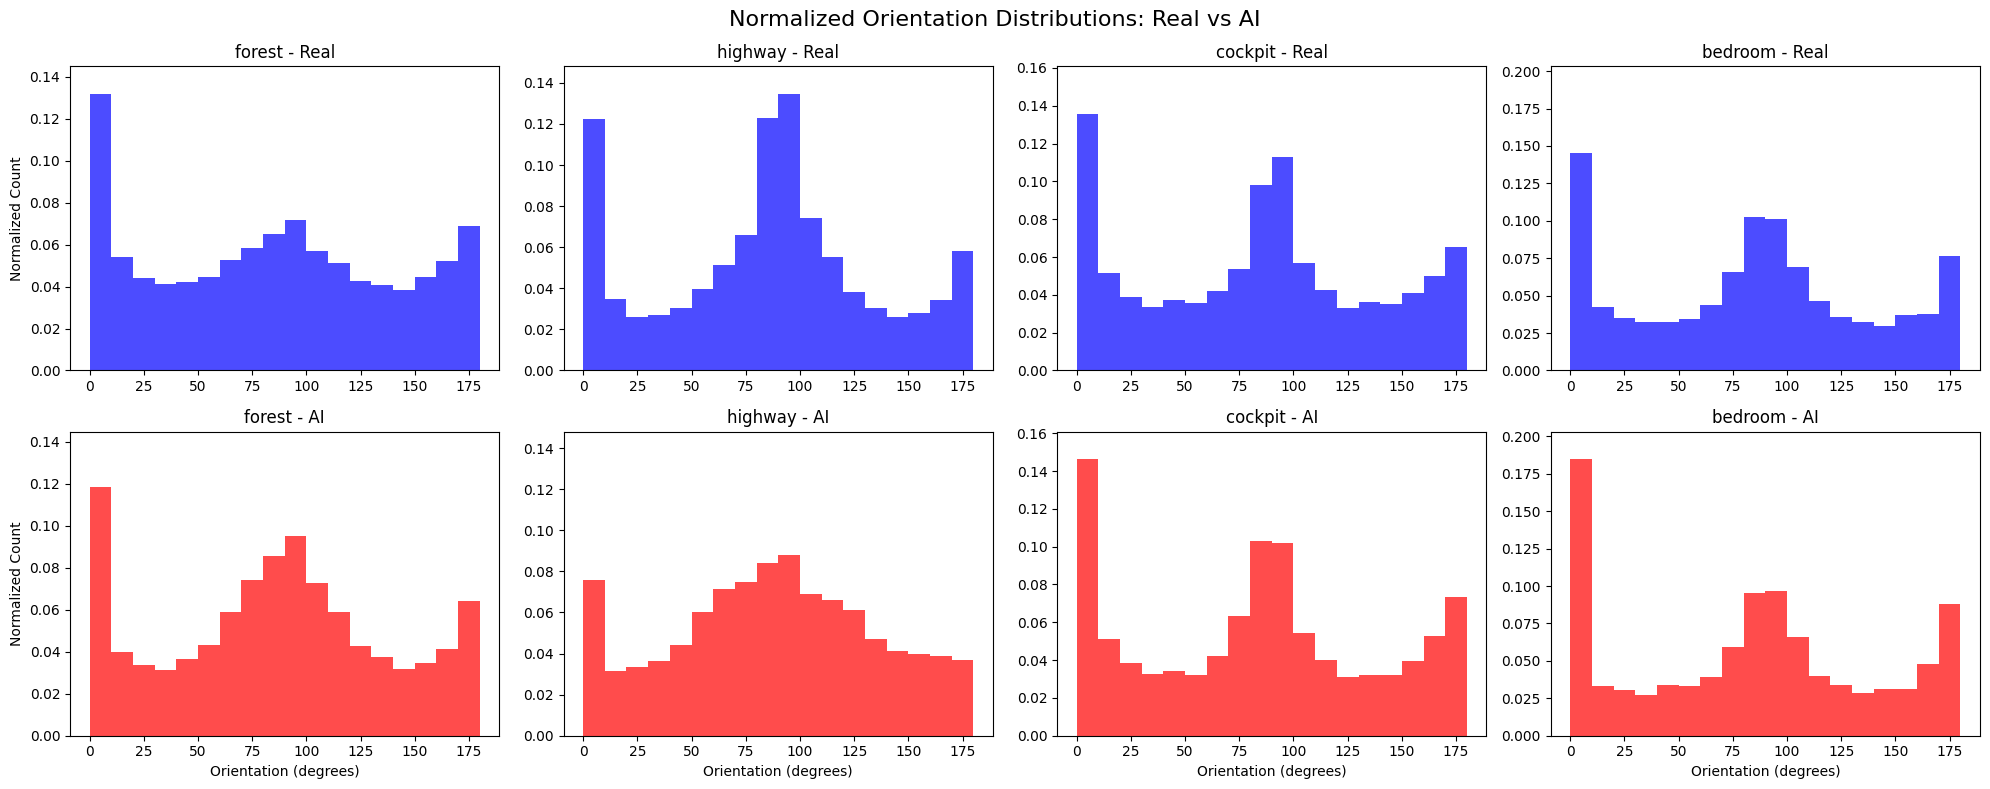

In [13]:
# Set up the figure
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle('Normalized Orientation Distributions: Real vs AI', size=16)

bins = np.linspace(0, 180, 19)

for idx, category in enumerate(scene_categories):
    # Get histograms for this category
    real_hists = df_sample[(df_sample['scene_category'] == category) & 
                          (df_sample['img_type'] == 'real')]['orientation_hist'].values
    ai_hists = df_sample[(df_sample['scene_category'] == category) & 
                        (df_sample['img_type'] == 'ai')]['orientation_hist'].values
    
    # Sum and normalize
    real_sum = np.sum(real_hists, axis=0)
    real_normalized = real_sum / np.sum(real_sum) if np.sum(real_sum) > 0 else real_sum
    
    ai_sum = np.sum(ai_hists, axis=0)
    ai_normalized = ai_sum / np.sum(ai_sum) if np.sum(ai_sum) > 0 else ai_sum
    
    # Find max y value for consistent scale
    y_max = max(real_normalized.max(), ai_normalized.max())
    
    # Plot normalized distributions
    bin_centers = (bins[:-1] + bins[1:]) / 2
    axs[0, idx].bar(bin_centers, real_normalized, width=10, color='blue', alpha=0.7)
    axs[1, idx].bar(bin_centers, ai_normalized, width=10, color='red', alpha=0.7)
    
    # Labels etc...
    axs[0, idx].set_title(f'{category} - Real')
    axs[1, idx].set_title(f'{category} - AI')
    axs[0, idx].set_ylim(0, y_max * 1.1)
    axs[1, idx].set_ylim(0, y_max * 1.1)
    
    if idx == 0:
        axs[0, idx].set_ylabel('Normalized Count')
        axs[1, idx].set_ylabel('Normalized Count')
    axs[1, idx].set_xlabel('Orientation (degrees)')

plt.tight_layout()
plt.show()

In [14]:
def plot_contour_distributions(df, stat_function, bins=100, use_log=True, log_base=10, clean_visual=False, sample_size = 75):
    """
    Plot histograms of contour statistics with consistent axes and streamlined labeling.
    
    Args:
        df: Input dataframe
        stat_function: Function that returns array of statistics for an image
        bins: Number of histogram bins
        use_log: Whether to use log scale for x-axis
        log_base: Base to use for log transformation (if use_log=True)
        clean_visual: If True, removes plot borders and tick marks
    
    Returns:
        tuple: (figure, axes) for further customization
    """
    fig, axes = plt.subplots(2, 6, figsize=(20, 8))
    categories = sorted(df['scene_category'].unique())
    
    hist_data = {}
    global_min = float('inf')
    global_max = float('-inf')
    max_count = 0
    
    # Compute histogram data and global limits
    for img_type in ['real', 'ai']:
        for category in categories:
            samples = df[(df['scene_category'] == category) & 
                        (df['img_type'] == img_type)].sample(sample_size)
            stats = np.concatenate([stat_function(img) for img in samples['img_path']])
            
            if use_log:
                stats = np.log(stats + 1) / np.log(log_base)
            
            global_min = min(global_min, np.min(stats))
            global_max = max(global_max, np.max(stats))
            
            counts, edges = np.histogram(stats, bins=bins)
            hist_data[(img_type, category)] = (counts, edges)
            max_count = max(max_count, np.max(counts))
    
    # Plot histograms
    for i, img_type in enumerate(['real', 'ai']):
        for j, category in enumerate(categories):
            counts, edges = hist_data[(img_type, category)]
            axes[i,j].hist(edges[:-1], edges, weights=counts)
            
            # Remove all existing titles
            axes[i,j].set_title('')
            
            axes[i,j].set_xlim(global_min, global_max)
            axes[i,j].set_ylim(0, max_count)
            
            if clean_visual:
                axes[i,j].spines['top'].set_visible(False)
                axes[i,j].spines['right'].set_visible(False)
                axes[i,j].spines['left'].set_visible(False)
                axes[i,j].spines['bottom'].set_visible(False)
                axes[i,j].set_xticks([])
                axes[i,j].set_yticks([])
            elif use_log:
                ticks = np.linspace(global_min, global_max, 5)
                axes[i,j].set_xticks(ticks)
                tick_labels = [f'{log_base**x:.0f}' for x in ticks]
                axes[i,j].set_xticklabels(tick_labels, rotation=45)
    
    # Add category labels at the top
    for j, category in enumerate(categories):
        axes[0,j].text(0.5, 1.1, category.capitalize(), 
                       fontsize=18,
                      horizontalalignment='center',
                      transform=axes[0,j].transAxes)
    
    # Add image type labels on the left
    fig.text(0, 0.6, 'Real Images', horizontalalignment='center', rotation=90, fontsize = 15)
    fig.text(0, 0.1, 'AI Images', horizontalalignment='center', rotation=90, fontsize = 15)
    
    plt.tight_layout()
    return fig, axes


In [ ]:
# count number of unique rows for each scene_category
category_counts = df.groupby('scene_category').size()

print(category_counts)

In [ ]:
# plot contour lengths
fig, axes = plot_contour_distributions(df, ct.get_contour_lengths, 
                                     bins=50, use_log=True, 
                                     log_base=10, clean_visual=True)
fig.suptitle('Contour Lengths by Scene Category and Image Type', fontsize=24, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.8)


In [ ]:
# plot contour orientations
fig, axes = plot_contour_distributions(df, ct.get_contour_orientations, 
                                     bins=50, use_log=False, 
                                     log_base=10, clean_visual=True)
fig.suptitle('Contour Orientation by Scene Category and Image Type', fontsize=24, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.8)


In [ ]:
# plot contour aspect ratios
fig, axes = plot_contour_distributions(df, ct.get_contour_aspect_ratios, 
                                     bins=50, use_log=True, 
                                     log_base=10, clean_visual=False)
fig.suptitle('Contour Aspect Ratio by Scene Category and Image Type', fontsize=24, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.8)


In [ ]:
# plot contour extent
fig, axes = plot_contour_distributions(df, ct.get_contour_extents, 
                                     bins=50, use_log=True, 
                                     log_base=10, clean_visual=False)
fig.suptitle('Contour Extent by Scene Category and Image Type', fontsize=24, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.8)
